# **Data Visualization**

## Objectives

* This notebook aims to answer Business Requirement 1:
  * The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.
* This notebook also aims to validate Hypothesis 1:
  * We hypothesize that infected leaves have clear white marks with which they can be distinguished from healthy leaves

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation

## Outputs

* Image shape pickle file.
* Mean and variability of images per label plot - original image size and reduced image size at 50x50 pixels
* Plot to distinguish the contrast between healthy and powdery-mildew affected leaf images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Additional Comments





---

# Prepare Data Directories

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project'

## Set input directories

We need to set the paths for our train, test and validation sets directories:

In [5]:
data_directory = 'inputs/cherry_leaves_dataset/cherry-leaves/'
train_path = os.path.join(data_directory, 'train')
val_path = os.path.join(data_directory, 'validation')
test_path = os.path.join(data_directory, 'test')

## Set output directory

Next we set our output directory, making sure to add a version number so we can version outputs from different sessions.

In [6]:
version = 1
output_path = f'outputs/v{version}'

if 'outputs' in os.listdir(os.getcwd()) and f'v{version}' in os.listdir(os.path.join(os.getcwd(), 'outputs')):
    print('Version already exists, create a new version')
else:
    os.makedirs(name = output_path)

Version already exists, create a new version


### Set label names

We also need to set the labels for the images

In [7]:
labels = os.listdir(train_path)
print(f'Labels for the images are {labels}')

Labels for the images are ['powdery_mildew', 'healthy']


---

# Data visualization of image data

## Image shape

As with tabular data as well, image data needs to be normalized to be used in a machine learning model. The first step we want to take is to find the average image size of our images of the train set. 

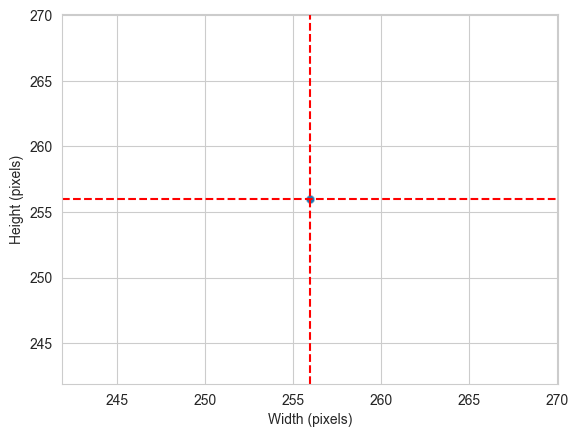

Width average: 256 
Height average: 256


In [8]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


As we can see in the plot above, in our case, all images are already at the same size of 256x256 pixels. In a real world scenario, this is unlikely and images may have very different dimensions. In such a case, one would take the average image size computed above and resize the images to the average. 

We then save this information in a variable, including the number of color channels, in our case 3 channels for RGB:

In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

And we save the image shape embeddings as a .pkl file

In [20]:
joblib.dump(value=image_shape,
            filename=f'{output_path}/image_shape.pkl')

['outputs/v1/image_shape.pkl']

---

## Average and variability of images per label

We are using the following function from Code Institute's malaria detector walkthrough project to load images into an array.

The function uses default values for resizing the images and how many images per label are getting processed. These default values can be overridden when calling the function with the desired values as function arguments. 

In [10]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


We are loading the image shapes and labels in an array. 

In our case, we are going with the size that we saved in our `image_shape` variable earlier. A smaller size may improve computing times and may be performing similarly. We will test this hypothesis when we are in the next notebook and training our model. 

In [11]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


The next step is to plot and save the mean and variability images per label. The function loops over all labels, subsets an array for a given label, calculates the mean and standard deviation, creates a figure displaying the mean and variability images and saves the image if desired.

In [12]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False, path_addition=''):

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{output_path}/avg_var_{label_to_display}{path_addition}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")


==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


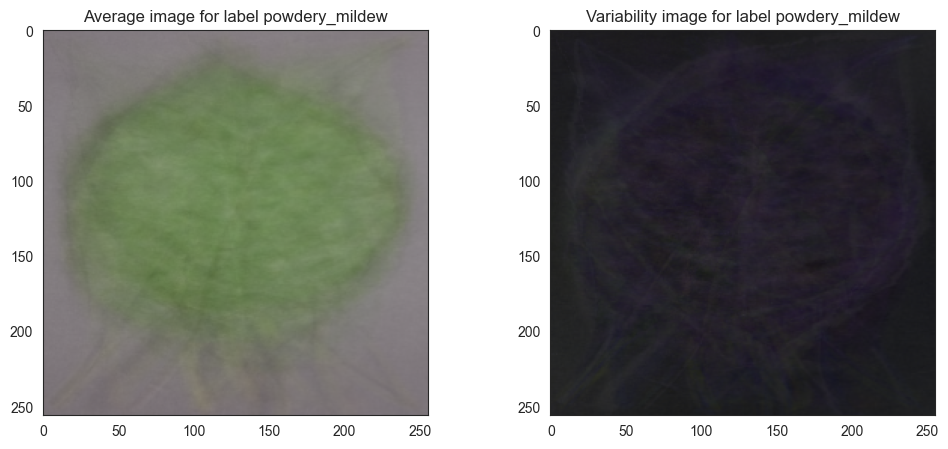

In [13]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)


### Checking average and variability images with a different image size

I am interested to see if the images differ when using a different image size, so I will load the images with a size of 50x50

In [29]:
X, y = load_image_as_array(my_data_dir=train_path,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 50, 50, 3) (60,)


==== Label healthy ====
Image Shape: (50, 50, 3)
==== Label powdery_mildew ====
Image Shape: (50, 50, 3)


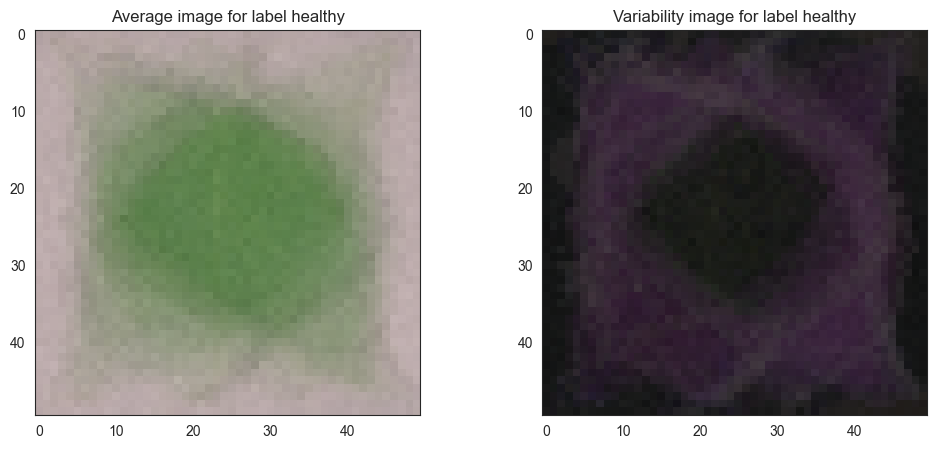

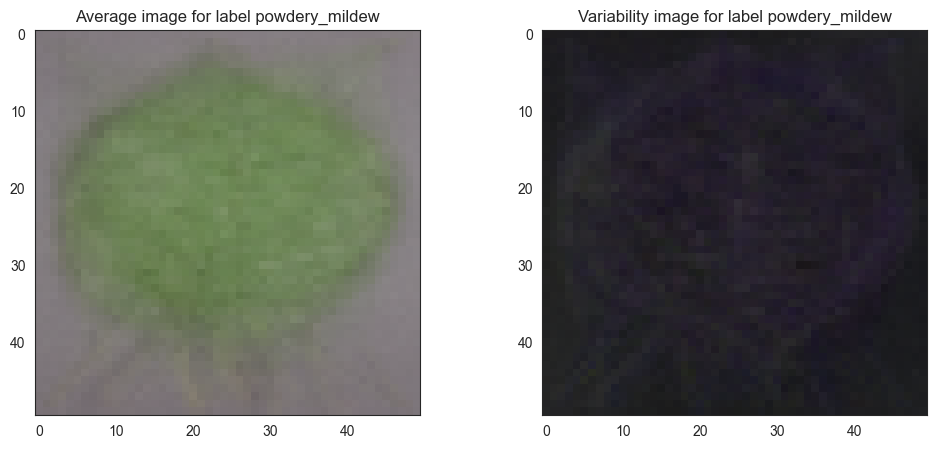

In [33]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True, path_addition='small')

We can see that the images are more pixelated, but the main features are still clearly visible. 

---

## Difference between average healthy and average powdery-mildew-affected leaf images

We can run the following function (taken from the CI malaria walkthrough project and adjusted using our variables) to display a difference between the average healthy and average affected leaf. 

In [14]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{output_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()


In [15]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---

## Image Montage

To create an image montage for the Streamlit dashboard, we are borrowing from the code from CI's malaria walkthrough project again:

In [16]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


We run the image montage on all existing labels:

In [17]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

powdery_mildew




healthy


---

# Conclusions and Next Steps

We have successfully executed the image study required for Business Requirement 1. 


The next step is the Modelling and Evaluation Notebook, in which we will fit and train a model to predict whether any given image of a cherry leaf shows a healthy or powdery-mildew affected cherry leaf. 